### Steps To Run:


1.   Change working directory in the "Directories" cell to match your current directory. PS: testing driectory is already set to ""/content/drive/MyDrive/COEN240/Testing""
2.   Run All the required cells
3.   To try on test data, you can directly run the "Tesing Data preparation" and "Model test" Cells. The testing data should be named as "1_0.jpeg" and labels.txt should have entries like "1 Name". This is the same as dataset 2 that was released.
4.   Data augmentaton and pre-processing does not have to be run since pre-processed data is already dumped to a pickle file.
5.   You can see random pre-processed smaples by running "See pre-processed training image" cell
6.   The "Remove Augmented Data" cell deleetd all the augmented data from the dataset folder in case you need to run augmentation again.





In [ ]:
#@title Mount Drive (Required)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Directories (Required)
import os
# Set current directy here
cwd = "/content/drive/Shareddrives/COEN-240 Group 9 Project Code + Slides"

# Define the relative paths
train_dir = os.path.join(cwd, "face_data/all_data")
face_train_pickle = os.path.join(cwd, "face_train.pickle")
model_svm_rbf = os.path.join(cwd, "model_svm_rbf.pkl")
model_pca = os.path.join(cwd, "model_pca.pkl")
model_lda = os.path.join(cwd, "model_lda.pkl")
model_scalar_standard = os.path.join(cwd, "model_scalar_standard.pkl")

#Setting test Dir to one specified
test_dir = os.path.join(cwd, "face_data/test_final")


In [ ]:
#@title Data Pre-processing methods (Required)
def pre_process(image):

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:

        face = gray[y:y+h, x:x+w]

        # Apply histogram equalization
        face = cv2.equalizeHist(face)

        # Resize the face image to a fixed size
        face = cv2.resize(face, (50, 50))
        # Normalize the pixel values to [0, 1]
        face = face.astype(np.float32) / 255.0
        face = face.flatten()
        return face

def flipped_image(image,imgpath):
     # Perform the horizontal flip
    flipped_image = np.fliplr(image)
    cv2.imwrite(str(imgpath+"_flipped_image.jpg"), flipped_image)

def rotate_image(image, angle):
    # Get the dimensions of the image
    (h, w) = image.shape[:2]
    # Compute the center of the image
    center = (w / 2, h / 2)
    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, M, (w, h))
    cv2.imwrite(str(imgpath+"_rotated_image.jpg"), rotated_image)

def scale_image(image, scale):
    # Perform the scaling
    scaled_image = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    cv2.imwrite(str(imgpath+"_scaled_image.jpg"), scaled_image)

def translate_image(image, x, y):
    # Get the dimensions of the image
    (h, w) = image.shape[:2]
    # Compute the translation matrix
    M = np.float32([[1, 0, x], [0, 1, y]])
    # Perform the translation
    translated_image = cv2.warpAffine(image, M, (w, h))
    cv2.imwrite(str(imgpath+"_translated_image.jpg"), translated_image)

def adjust_brightness(image, value):
    # Convert the image to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Adjust the brightness
    hsv[:,:,2] += value
    # Convert the image back to BGR
    bright_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    cv2.imwrite(str(imgpath+"_bright_image.jpg"), bright_image)

In [ ]:
#@title Remove Augmented Data (Required before running augmentation cell)
import os
import glob

# Load the image
dir = train_dir
categories = os.listdir(dir)
if '.DS_Store' in categories:
  categories.remove('.DS_Store')

# List of suffixes used for augmented images
suffixes = ["_flipped_image.jpg", "_rotated_image.jpg", "_scaled_image.jpg", "_translated_image.jpg", "_bright_image.jpg"]

for category in categories:
    path = os.path.join(dir, category)
    try:
        for suffix in suffixes:
            # Find all augmented images
            augmented_images = glob.glob(os.path.join(path, "*"+suffix))
            for imgpath in augmented_images:
                # Remove the image
                os.remove(imgpath)
                print(f"Removed {imgpath}")
    except Exception as e:
        print(e)


In [ ]:
#@title Data Augmentation (~3 minutes)
import os
import numpy as np
import cv2
import pickle
import sys

# Load the image
dir = train_dir
categories = os.listdir(dir)
if '.DS_Store' in categories:
  categories.remove('.DS_Store')

for category in categories:
        path = os.path.join(dir, category)
        try:
            for img in os.listdir(path):
                imgpath = os. path.join(path, img)
                image = cv2.imread(imgpath)
                if image is not None:
                    flipped_image(image,imgpath)
                    rotate_image(image, 45)  # Rotate by 45 degrees
                    scale_image(image, 1.2)  # Scale up by 20%
                    translate_image(image, 10, 10)  # Translate by 10 pixels in both directions
                    adjust_brightness(image, 50)  # Increase brightness by 50

        except Exception as e:
            print(e)


In [ ]:
#@title Training Data Preparation (~3 Minutes)
import os
import numpy as np
import cv2
import pickle
import sys

#Add directories to our photos
dir = train_dir

categories = os.listdir(dir)
if '.DS_Store' in categories:
  categories.remove('.DS_Store')
data_train = []
data_test = []

data = []

for category in categories:
        path = os.path.join(dir, category)
        try :
            label = categories.index(category)
            for img in os.listdir(path):
                imgpath = os. path.join(path, img)
                image = cv2.imread(imgpath)
                if image is not None:
                    image_pre = pre_process(image)
                    if image_pre is not None:
                        data_train.append([image_pre,"".join(category.split())])
        except Exception as e:
            print(e)

print("Number of images in Training Data:", len(data_train))

pick_in = open('/content/drive/Shareddrives/COEN 240 - Machine Learning Group Project/face_train.pickle', 'wb')
pickle.dump(data_train, pick_in)
pick_in.close()

Number of images in Training Data: 1011


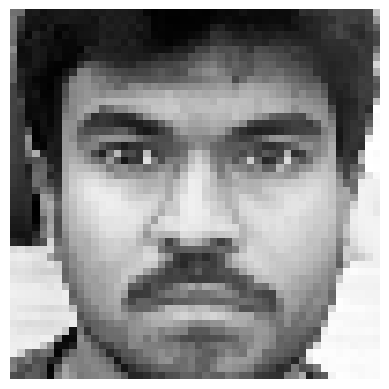

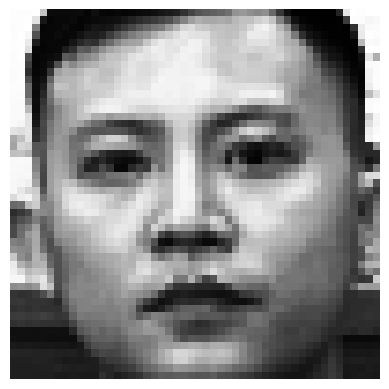

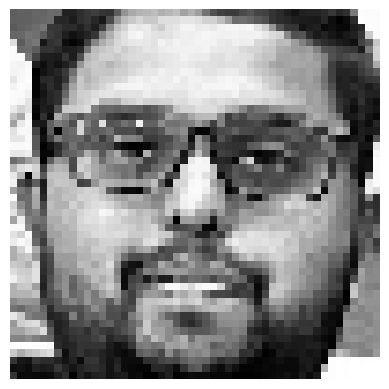

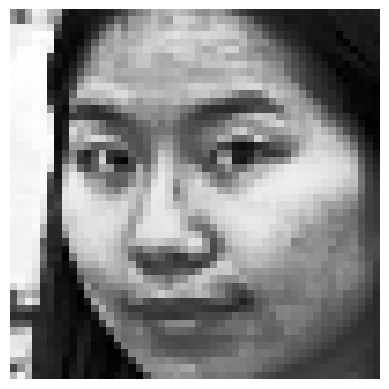

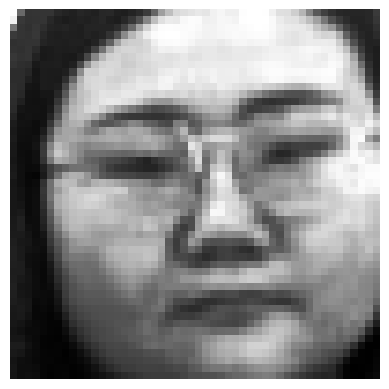

In [ ]:
#@title See pre-processed training image
import matplotlib.pyplot as plt
import pickle
import numpy as np

# Load the training data
pick_in = open(face_train_pickle, 'rb')
data_train = pickle.load(pick_in)
pick_in.close()

# Check if there is any data
if len(data_train) > 0:
    # Get 5 random indices from the training data
    random_indices = np.random.choice(len(data_train), 5, replace=False)
    for i in random_indices:
        # Get the image and label from the training data
        image, label = data_train[i]

        # Reshape the image back to its original shape
        reshaped_image = image.reshape(50, 50)

        # Display the image
        plt.imshow(reshaped_image, cmap='gray')
        plt.axis('off')
        plt.show()
else:
    print("No training data available.")


In [ ]:
#@title Model Train + Validation
import pickle
import numpy as np
import pandas as pd
import random
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier

pick_in = open(face_train_pickle, 'rb')
data_train = pickle.load(pick_in)
pick_in.close()

xtrain = []
ytrain = []
feature =[]
labels = []


for i in data_train:

    xtrain.append(i[0])
    ytrain.append(i[1])

# Split your training data into a training set and a validation set
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.1, random_state=42)

# For dimensionality reduction
pca = PCA(n_components=120)
xtrain = pca.fit_transform(xtrain)
xval = pca.transform(xval)  # transform validation data

# LDA
lda = LDA(n_components=25)
xtrain = lda.fit_transform(xtrain, ytrain)
xval = lda.transform(xval)  # transform validation data

# Scaling Data
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xval = scaler.transform(xval)  # scale validation data

exp_var = sum(pca.explained_variance_ratio_ * 100)
print('Variance explained:', exp_var)

# Define the model
model = SVC(C=10, gamma=0.001,kernel='rbf',class_weight='balanced')
#model = KNeighborsClassifier(n_neighbors=2)

# Train the model on the training set
model.fit(xtrain, ytrain)

# Evaluate the model on the validation set
y_pred_val = model.predict(xval)
print('Validation Accuracy: %.3f' % accuracy_score(yval, y_pred_val))

# Calculate F1 score on validation set
f1_val = f1_score(yval, y_pred_val,average='micro')
print('Validation F1 Score:', f1_val)

# Calculate recall on validation set
recall_val = recall_score(yval, y_pred_val,average='micro')
print('Validation Recall:', recall_val)

# Save the model
with open(model_svm_rbf, 'wb') as f:
    pickle.dump(model, f)

# Save the PCA transformer
with open(model_pca, 'wb') as f:
    pickle.dump(pca, f)

# Save the PCA transformer
with open(model_lda, 'wb') as f:
    pickle.dump(lda, f)

# Save the standard scaler
with open(model_scalar_standard, 'wb') as f:
    pickle.dump(scaler, f)

Variance explained: 86.93708002872643
Validation Accuracy: 0.931
Validation F1 Score: 0.9313725490196079
Validation Recall: 0.9313725490196079


In [ ]:
#@title Tesing Data preparation (~10 sec for dataset with 126 images)
import pandas as pd
import os
import numpy as np
import cv2
import pickle
import sys

labels_df = pd.read_csv(test_dir+ '/labels.txt', sep='\t', header=None)
labels_dict = dict(zip(labels_df[0], labels_df[1]))
data_test_new = []
for img in os.listdir(test_dir):
    imgpath = os.path.join(test_dir, img)
    image = cv2.imread(imgpath)
    if image is not None:
        # Extract the image number from the filename
        # Get the label from the dictionary
        label = labels_dict[img]
        image_pre = pre_process(image)
        if image_pre is not None:
            data_test_new.append([image_pre, label])
print("Number of images in Training Data:", len(data_test_new))

Number of images in Training Data: 112


In [ ]:
#@title Model Test
import pickle
from sklearn.metrics import accuracy_score, f1_score, recall_score
import matplotlib.pyplot as plt

xtest = []
ytest = []

for i in data_test_new:

    xtest.append(i[0])
    ytest.append(i[1])

# Load the trained model
with open(model_svm_rbf, 'rb') as f:
    model = pickle.load(f)

# Load the PCA transformer
with open(model_pca, 'rb') as f:
    pca = pickle.load(f)

# Load the LDA transformer
with open(model_lda, 'rb') as f:
    lda = pickle.load(f)

# Load the standard scaler
with open(model_scalar_standard, 'rb') as f:
    scaler = pickle.load(f)

# Transform and scale the test data
xtest = pca.transform(xtest)
xtest = lda.transform(xtest)
xtest = scaler.transform(xtest)

# Finally, evaluate the model on the test set
y_pred = model.predict(xtest)
print('Test Accuracy: %.3f' % accuracy_score(ytest, y_pred))

# Calculate F1 score on test set
f1 = f1_score(ytest, y_pred,average='micro')
print('Test F1 Score:', f1)

# Calculate recall on test set
recall = recall_score(ytest, y_pred,average='micro')
print('Test Recall:', recall)

### Un-commnt this to see predicted images from test data
# for i in range(len(data_test_new)):
#   if(y_pred[i] == 'Husain'):
#     # Get the first image from the training data
#     image, label = data_test_unprocessed[i]

#     # Display the image
#     plt.imshow(image, cmap='gray')
#     plt.title('Predicted: ' + y_pred[i] + '\n' + 'Actually is: ' + label)
#     plt.axis('off')
#     plt.show()

Test Accuracy: 0.670
Test F1 Score: 0.6696428571428571
Test Recall: 0.6696428571428571
